In [2]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
import model_helper 
from helper import *
from scipy.stats import iqr

In [3]:
# Load wbc and treatment file 
wbc_df = pd.read_csv('CLL8 CLL cell count 10282024 UPDATED.csv')
treatment = pd.read_csv("GCLL_0019.txt", sep = '\t')

# Get input files from Terra through dalmatian
patient = 'GCLL-0199'
workspace ='broad-firecloud-ibmwatson/TAG_CLL_Clonal_Kinetic_UMI_PrAN'
wm = dalmatian.WorkspaceManager(workspace)

participants = wm.get_participants()


cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs'], sep='\t')

abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv'], sep='\t')

In [4]:
# Select the wbc data for the patient

In [5]:
wbc_df_0199 = wbc_df[wbc_df['Patient'] == patient]
sample_list = wbc_df_0199['Timepoint'].dropna().tolist()

times_sample = [ int(i) for i in wbc_df_0199.loc[wbc_df_0199.Sample.notna(), 'Time_since_start_tx'].tolist()]
CLL_count = [float(i) for i in wbc_df_0199.loc[wbc_df_0199.Sample.notna(),'CLL count estm'].tolist()]

In [6]:
wbc_df_0199

,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample
293,27.0,GCLL-0199,7/15/04,10/8/05,4/11/05,-180,7.90,0.5300000000,NaN,4.18700000,GCLL-0199-T-01,CLL-GCLL-0199-Tumor-SM-41K3U
294,27.0,GCLL-0199,7/15/04,10/8/05,1/2/06,86,4.30,0.0000000000,1.0,0.00000000,NaN,NaN
295,27.0,GCLL-0199,7/15/04,10/8/05,4/12/06,186,4.30,0.0000000000,1.0,0.00000000,NaN,NaN
296,27.0,GCLL-0199,7/15/04,10/8/05,6/12/06,247,4.30,0.0000000000,1.0,0.00000000,NaN,NaN
297,27.0,GCLL-0199,7/15/04,10/8/05,10/5/06,362,4.30,0.0000000000,1.0,0.00000000,NaN,NaN
298,27.0,GCLL-0199,7/15/04,10/8/05,2/1/07,481,4.30,0.0000973310,1.0,0.00000000,NaN,NaN
299,27.0,GCLL-0199,7/15/04,10/8/05,5/31/07,600,4.30,0.0001042116,0.0,0.00044811,NaN,NaN
300,27.0,GCLL-0199,7/15/04,10/8/05,9/17/07,709,4.30,0.0003184763,0.0,0.00136945,NaN,NaN
301,27.0,GCLL-0199,7/15/04,10/8/05,1/10/08,824,4.30,0.0011104536,0.0,0.00477495,NaN,NaN
302,27.0,GCLL-0199,7/15/04,10/8/05,8/13/08,1040,4.30,0.0040994318,0.0,0.01762756,NaN,NaN


In [7]:
CLL_count

[4.187, 0.02481217, 0.06480998, 0.1338666, 4.98022376, 5.75216118, 15.97161629]

In [8]:
times_sample

[-180, 1138, 1257, 1341, 1630, 1959, 2370]

In [9]:
# Select the UMI timepoints with index
UMI_start = 1
UMI_end = 4

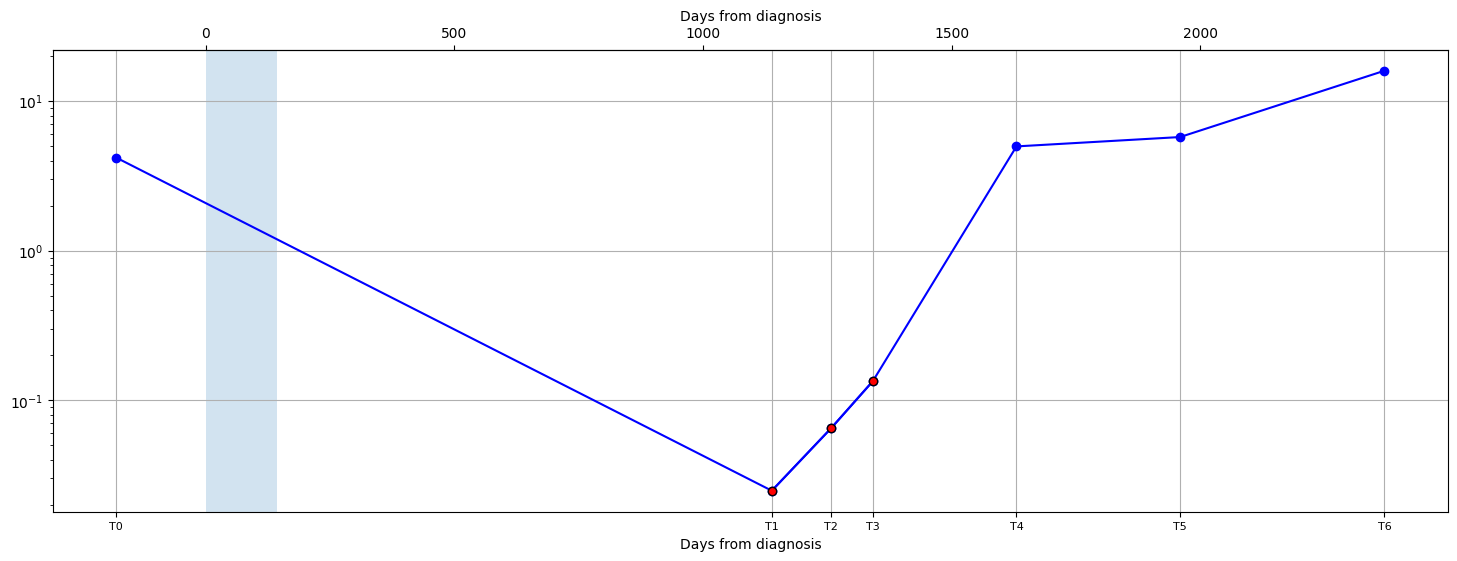

In [10]:
fig,ax = plt.subplots(1,1, figsize=(18,6))
ax.semilogy(times_sample,CLL_count,marker = 'o', color='blue')

# Create a scatter plot for the UMI timepoints with the red color
ax.semilogy(times_sample[UMI_start:UMI_end], CLL_count[UMI_start:UMI_end], color='blue',markerfacecolor='red',mec='black', marker = 'o')


# Fludarabine treatment 
ax.axvspan(xmin = 0, xmax= 143, label = "Fludarabine", alpha = 0.2)
ax.set_xlabel('Days from diagnosis')


number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]
ax.set_xticks(times_sample)
ax.set_xticklabels(tick_list, fontsize =8)

secax = ax.secondary_xaxis('top')
secax.set_xlabel('Days from diagnosis')
ax.grid(True)

Subclonal modeling

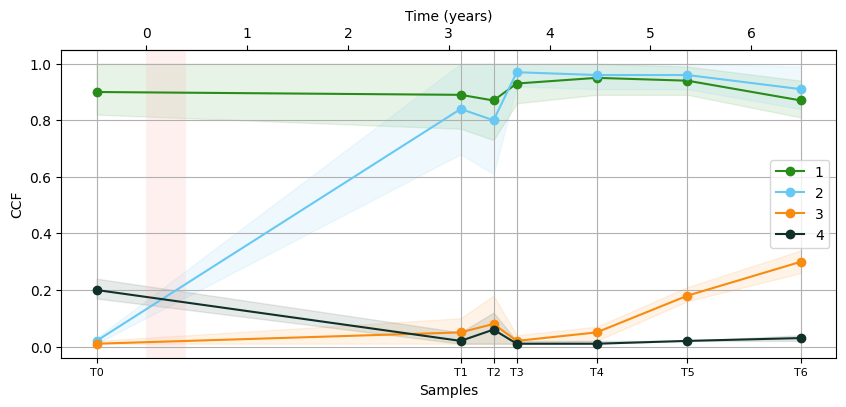

In [11]:
fig, ax = plt.subplots(figsize = (10, 4))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [12]:
abundance_df.Sample_ID.unique()

array(['GCLL-0199-T-02', 'GCLL-0199-T-03', 'GCLL-0199-T-01',
       'GCLL-0199-T-04',
       'RP-1895_PDO-33508_SM-NKK1O_GCLL-0199-MRD-03_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK1C_GCLL-0199-MRD-01_v1_Custom_Selection_OnPrem',
       'RP-1895_PDO-33508_SM-NKK1E_GCLL-0199-MRD-02_v1_Custom_Selection_OnPrem'],
      dtype=object)

In [78]:
# Manually verify the sample list order is correct

In [13]:
sample_list = ['GCLL-0199-T-01','RP-1895_PDO-33508_SM-NKK1C_GCLL-0199-MRD-01_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKK1E_GCLL-0199-MRD-02_v1_Custom_Selection_OnPrem','RP-1895_PDO-33508_SM-NKK1O_GCLL-0199-MRD-03_v1_Custom_Selection_OnPrem','GCLL-0199-T-02',
 'GCLL-0199-T-03',
 'GCLL-0199-T-04']

In [14]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [17]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(CLL_count, cluster_abundance, cluster_list)


In [91]:
log_subclone_sample

{1: [1.075452390038021,
  -12.906761392347464,
  -11.946636047113095,
  -11.221251869257003,
  -7.604865550222113,
  -7.460764730392315,
  -6.4395272069806415],
 2: [-7.7783558849391765,
  -3.9576559228082138,
  -2.852717138154164,
  -2.1051122926796464,
  1.500225411034972,
  1.4620268935773215,
  2.226258388485423],
 3: [-3.163235368097917,
  -7.199651127598588,
  -6.23952578236422,
  -6.606131352415742,
  -1.8977552854732376,
  -0.021793137996452834,
  1.5999527121198076],
 4: [-0.17695355035544302,
  -8.291640875506204,
  -11.946636047113095,
  -11.221251869257003,
  -7.604865550222113,
  -7.460764730392315,
  -0.7324169422317656]}

In [18]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [21]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01):
    
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [23]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(CLL_count, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [86]:
# Get the times at the start of the treatment and after 
all_times = [int(i) for i in wbc_df_0199['Time_since_start_tx'].to_list()]

times_aft_tx = [x for x in all_times if x > 143]
times_aft_tx.insert(0, 143)

In [87]:
times_aft_tx

[143,
 186,
 247,
 362,
 481,
 600,
 709,
 824,
 1040,
 1138,
 1257,
 1341,
 1630,
 1959,
 2370]

In [89]:
times_sample

[-180, 1138, 1257, 1341, 1630, 1959, 2370]

In [28]:
# time of the first sample after treatment
t_1st_af_tr = 1138

In [29]:
# Get the times after treatment but before the first sample after treatment
times_for_wbc_est = [x for x in all_times if x > 143 and x <t_1st_af_tr]

In [96]:
# Linear Regression Modeling

In [97]:
CLL_count

[4.187, 0.02481217, 0.06480998, 0.1338666, 4.98022376, 5.75216118, 15.97161629]

In [77]:
# Set the extrapolate time after treatment
extrapolate_start_idx = 1
extrapolate_end_idx = 6

extrapolate_times =times_sample[extrapolate_start_idx:]

In [99]:
extrapolate_times

[1138, 1257, 1341, 1630, 1959, 2370]

In [90]:
CLL_count

[4.187, 0.02481217, 0.06480998, 0.1338666, 4.98022376, 5.75216118, 15.97161629]

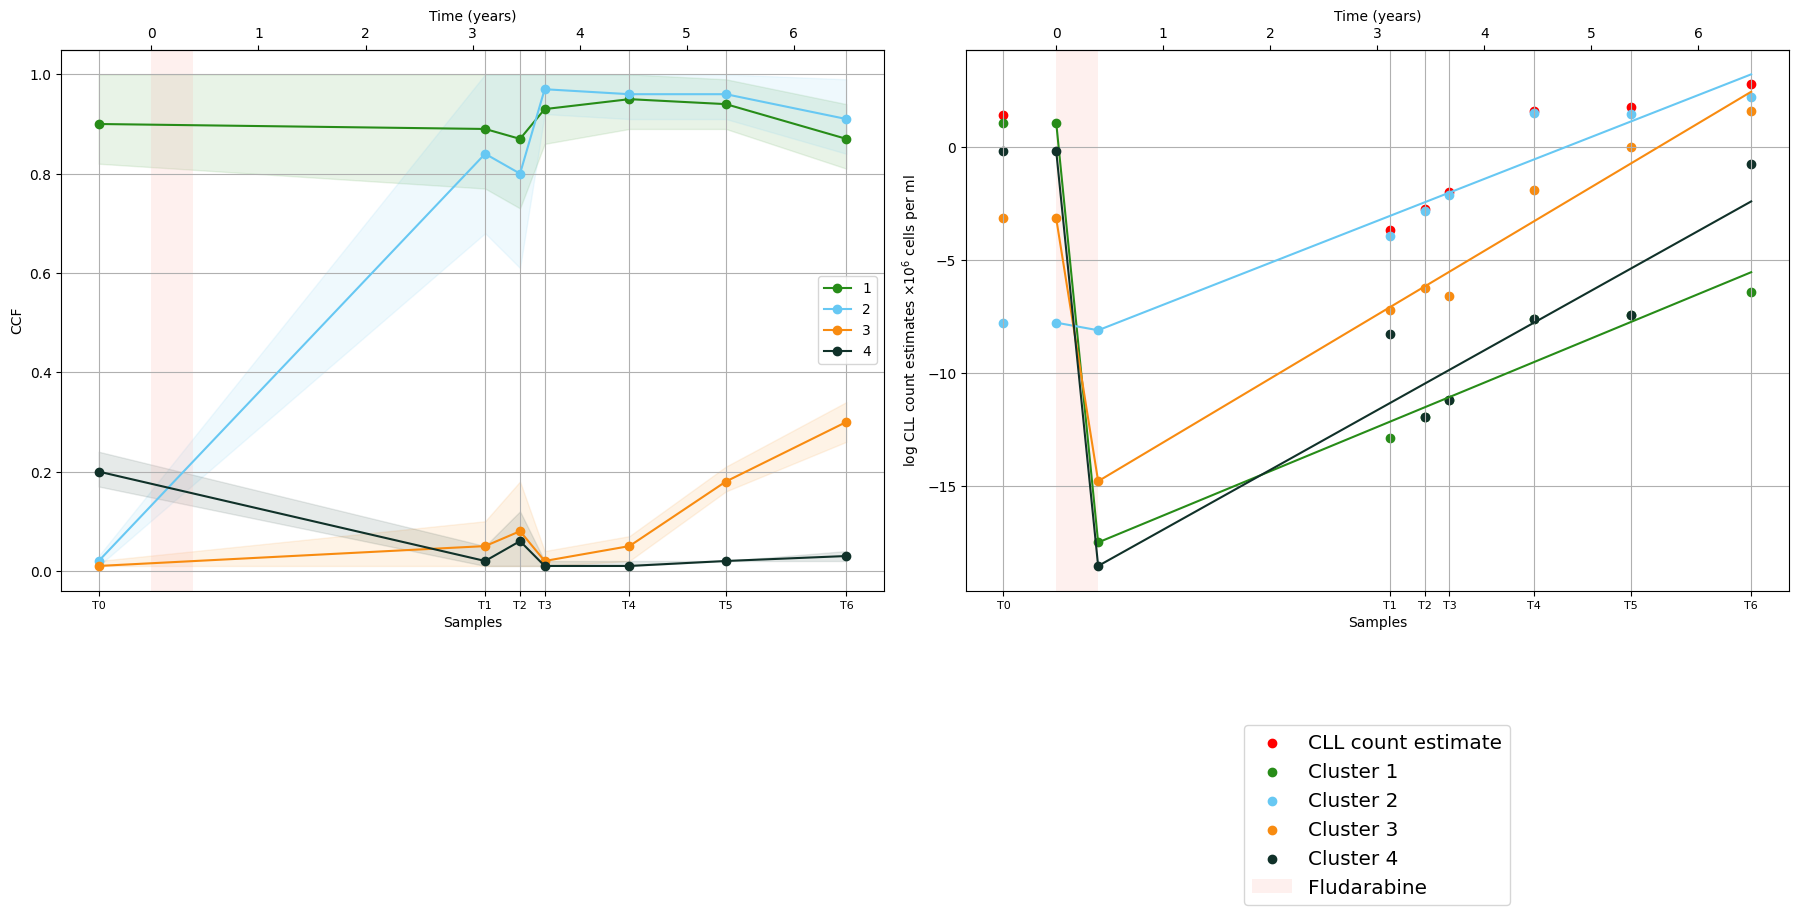

In [100]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        
        
        
#         print(predict_x, predicted)
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


    
    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [101]:
# Estimating total wbc after treatment using logsumexp

In [102]:
from scipy.special import logsumexp

[0.0003727423485524927, 0.0005085213161270546, 0.0009134486000806229, 0.001674959598839119, 0.003072272233917981, 0.0053571838471297255, 0.009636743718926609, 0.02909360758428876]


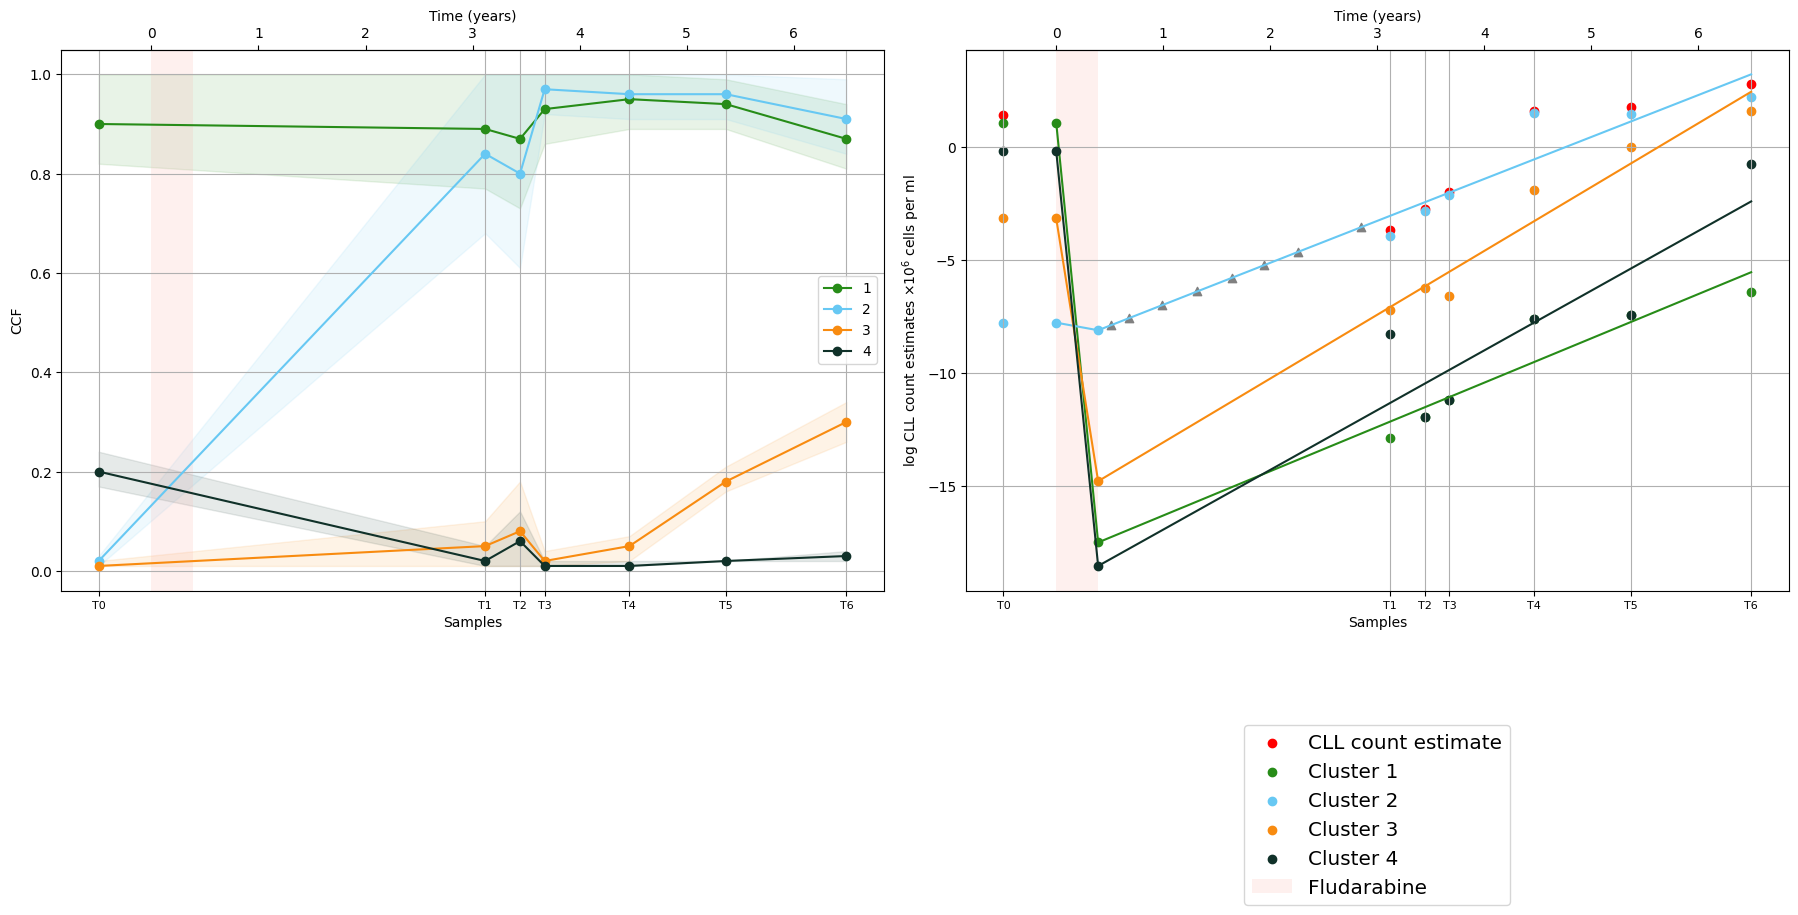

In [103]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]

predicted_end_tx_clones = []

def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        ## for wbc prediction after treatment
        times_for_wbc_est_year = [ i/365 for i in np.array(times_for_wbc_est)]
        cluster_cell_population[i] = np.polyval(model,times_for_wbc_est_year)
        
        
        predicted_end_tx_clones.append(predicted[0])
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

    ## Adding predicted wbc after treatment
   
    wbc_predicted =[]
    for timepoint in range(len(times_for_wbc_est)):
        predicted_all_subclone =[]
        for cluster in clusters:
            predicted_subclone = cluster_cell_population[cluster][timepoint]
            predicted_all_subclone.append(predicted_subclone)
        
        wbc_predicted.append(logsumexp(predicted_all_subclone))
        
    wbc_original = [ np.exp(i) for i in wbc_predicted]
    print(wbc_original)
    
    plt.scatter(times_for_wbc_est_year, wbc_predicted, color='grey',marker='^', alpha = 1)
    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')




## Assume exponential decrease during treatment and constant subclonal composition before treatment 

 
times_during_tx = [0,143/365]

tx_start_clones=[]
clusters = [1,2,3, 4]
for i in clusters:
    tx_start_clones.append(log_subclone_sample[i][0])




for i in clusters:
    ax2.plot(times_during_tx, [tx_start_clones[i-1], predicted_end_tx_clones[i-1]], color=ClusterColors.get_hex_string(i), marker = 'o')




In [104]:


wbc_df_0199 = wbc_df[wbc_df['Patient'] == patient]



wbc_df_0199 = wbc_df_0199.reset_index()

wbc_df_0199.loc[2:9, 'Estimated_CLL_extrap'] = wbc_original

wbc_df_0199['MRD'] = wbc_df_0199['MRD'].astype(float)
wbc_df_0199.loc[2:9, 'Estimated_WBC_extrap'] = wbc_df_0199['Estimated_CLL_extrap']/wbc_df_0199['MRD'] 

wbc_df_0199

,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap,Estimated_WBC_extrap
0,293,27.0,GCLL-0199,7/15/04,10/8/05,4/11/05,-180,7.90,0.530000,NaN,4.18700000,GCLL-0199-T-01,CLL-GCLL-0199-Tumor-SM-41K3U,NaN,NaN
1,294,27.0,GCLL-0199,7/15/04,10/8/05,1/2/06,86,4.30,0.000000,1.0,0.00000000,NaN,NaN,NaN,NaN
2,295,27.0,GCLL-0199,7/15/04,10/8/05,4/12/06,186,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.000373,inf
3,296,27.0,GCLL-0199,7/15/04,10/8/05,6/12/06,247,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.000509,inf
4,297,27.0,GCLL-0199,7/15/04,10/8/05,10/5/06,362,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.000913,inf
5,298,27.0,GCLL-0199,7/15/04,10/8/05,2/1/07,481,4.30,0.000097,1.0,0.00000000,NaN,NaN,0.001675,17.208902
6,299,27.0,GCLL-0199,7/15/04,10/8/05,5/31/07,600,4.30,0.000104,0.0,0.00044811,NaN,NaN,0.003072,29.481096
7,300,27.0,GCLL-0199,7/15/04,10/8/05,9/17/07,709,4.30,0.000318,0.0,0.00136945,NaN,NaN,0.005357,16.821295
8,301,27.0,GCLL-0199,7/15/04,10/8/05,1/10/08,824,4.30,0.001110,0.0,0.00477495,NaN,NaN,0.009637,8.678205
9,302,27.0,GCLL-0199,7/15/04,10/8/05,8/13/08,1040,4.30,0.004099,0.0,0.01762756,NaN,NaN,0.029094,7.096985


In [105]:
# Adding iterations in the wbc estimation 

In [106]:
log_subclone_sample_mcmc_with_uniform_noise[1]

{0: [1.081102485627847,
  -5.567785651648926,
  -8.471415687336377,
  -7.643532902207989,
  -1.288343465015905,
  -4.136892352861524,
  -2.3337553069228973],
 1: [1.0713041062128454,
  -8.856498335414205,
  -3.9036361168656084,
  -7.638097474483645,
  -2.9912588065212873,
  -2.8841522662995907,
  -1.9050675222290159],
 2: [1.1647991785121132,
  -5.571028142452197,
  -3.9660906646369365,
  -7.662668317307868,
  -3.939703469932086,
  -4.378950423026045,
  -3.20679578948356],
 3: [1.142073275066422,
  -9.033139681773703,
  -8.671331425369772,
  -6.755807756644939,
  -1.7381693867791452,
  -3.1635652040908644,
  -3.3126918684269255],
 4: [1.123373444065913,
  -4.901906038330941,
  -7.001223609939822,
  -6.702865045595874,
  -3.004784423443833,
  -3.331272768188544,
  -0.3278662041002102],
 5: [1.1961828135189807,
  -5.319382045900485,
  -4.808599776974753,
  -6.534081497401165,
  -0.17672893389404062,
  -3.723260345135234,
  -2.1806255518696456],
 6: [1.0415890334861204,
  -5.3204482153172

In [107]:


predicted_end_tx_clones = []

wbc_original_all_iterations = {}
def estimate_wbc(clusters):
    
        
    # plot total wbc
    
    for iter_idx in range(250):
    
        x_year = [ i/365 for i in np.array(times_sample)]
        

        # Extrapolate after treatment 
        cluster_cell_population = {}

        for i in clusters:
            x_year = [ i/365 for i in np.array(times_sample)]
            y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[i][iter_idx])

            # Extrapolate after treatment
            extrapolate_times =times_sample[extrapolate_start_idx:]
            extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
            extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[i][iter_idx][extrapolate_start_idx:]

            model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

            predict_x = times_aft_tx

            predict_year = [ i/365 for i in np.array(predict_x)]
            predicted = np.polyval(model, predict_year)

            ## for wbc prediction after treatment
            times_for_wbc_est_year = [ i/365 for i in np.array(times_for_wbc_est)]
            cluster_cell_population[i] = np.polyval(model,times_for_wbc_est_year)


            predicted_end_tx_clones.append(predicted[0])

    ## Adding predicted wbc after treatment
   
        wbc_predicted =[]
        for timepoint in range(len(times_for_wbc_est)):
            predicted_all_subclone =[]
            for cluster in clusters:
                predicted_subclone = cluster_cell_population[cluster][timepoint]
                predicted_all_subclone.append(predicted_subclone)

            wbc_predicted.append(logsumexp(predicted_all_subclone))

        wbc_original = [ np.exp(i) for i in wbc_predicted]
        wbc_original_all_iterations[iter_idx] = wbc_original

estimate_wbc([1,2,3, 4])


In [108]:
wbc_original_all_iterations[1]

[0.0003033180574929663,
 0.00041740544255501583,
 0.0007622342679058886,
 0.0014220306994809247,
 0.0026544011495921206,
 0.004704368764450369,
 0.008610856017892955,
 0.026879280112415176]

In [109]:
# Calculate the mean and confidence interval

num_elements = len(next(iter(wbc_original_all_iterations.values())))

# Initialize lists to store results
wbc_original_means = []
percentiles_2_5 = []
percentiles_97_5 = []

# Iterate over each position  in the lists
for i in range(num_elements):
    # Extract elements at the current position across all lists
    elements_at_position = [sublist[i] for sublist in wbc_original_all_iterations.values()]
    
    # Calculate the mean
    mean = np.mean(elements_at_position)
    wbc_original_means.append(mean)
    
    percentile_2_5 = np.percentile(elements_at_position, 2.5)
    percentile_97_5 = np.percentile(elements_at_position, 97.5)
    
    percentiles_2_5.append(percentile_2_5)
    percentiles_97_5.append(percentile_97_5)

In [110]:
wbc_df_0199 = wbc_df[wbc_df['Patient'] == patient]



wbc_df_0199 = wbc_df_0199.reset_index()

wbc_df_0199.loc[2:9, 'Estimated_CLL_extrap_mean'] = wbc_original_means
wbc_df_0199.loc[2:9, 'Estimated_CLL_extrap_2_5'] = percentiles_2_5
wbc_df_0199.loc[2:9, 'Estimated_CLL_extrap_97_5'] = percentiles_97_5


wbc_df_0199['MRD'] = wbc_df_0199['MRD'].astype(float)
wbc_df_0199.loc[2:9, 'Estimated_WBC_extrap_mean'] = wbc_df_0199['Estimated_CLL_extrap_mean']/wbc_df_0199['MRD'] 
wbc_df_0199.loc[2:9, 'Estimated_WBC_extrap_2_5'] = wbc_df_0199['Estimated_CLL_extrap_2_5']/wbc_df_0199['MRD'] 
wbc_df_0199.loc[2:9, 'Estimated_WBC_extrap_97_5'] = wbc_df_0199['Estimated_CLL_extrap_97_5']/wbc_df_0199['MRD'] 

wbc_df_0199

,index,Pt no.,Patient,Date of diagnosis,Date of treatment,Date of sample,Time_since_start_tx,WBC,MRD,MRD negative,CLL count estm,Timepoint,Sample,Estimated_CLL_extrap_mean,Estimated_CLL_extrap_2_5,Estimated_CLL_extrap_97_5,Estimated_WBC_extrap_mean,Estimated_WBC_extrap_2_5,Estimated_WBC_extrap_97_5
0,293,27.0,GCLL-0199,7/15/04,10/8/05,4/11/05,-180,7.90,0.530000,NaN,4.18700000,GCLL-0199-T-01,CLL-GCLL-0199-Tumor-SM-41K3U,NaN,NaN,NaN,NaN,NaN,NaN
1,294,27.0,GCLL-0199,7/15/04,10/8/05,1/2/06,86,4.30,0.000000,1.0,0.00000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,295,27.0,GCLL-0199,7/15/04,10/8/05,4/12/06,186,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.000479,0.000294,0.001040,inf,inf,inf
3,296,27.0,GCLL-0199,7/15/04,10/8/05,6/12/06,247,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.000628,0.000406,0.001265,inf,inf,inf
4,297,27.0,GCLL-0199,7/15/04,10/8/05,10/5/06,362,4.30,0.000000,1.0,0.00000000,NaN,NaN,0.001064,0.000740,0.001812,inf,inf,inf
5,298,27.0,GCLL-0199,7/15/04,10/8/05,2/1/07,481,4.30,0.000097,1.0,0.00000000,NaN,NaN,0.001871,0.001377,0.002667,19.221607,14.142564,27.405311
6,299,27.0,GCLL-0199,7/15/04,10/8/05,5/31/07,600,4.30,0.000104,0.0,0.00044811,NaN,NaN,0.003336,0.002558,0.004259,32.015350,24.543594,40.865236
7,300,27.0,GCLL-0199,7/15/04,10/8/05,9/17/07,709,4.30,0.000318,0.0,0.00136945,NaN,NaN,0.005721,0.004527,0.006811,17.964490,14.214178,21.386321
8,301,27.0,GCLL-0199,7/15/04,10/8/05,1/10/08,824,4.30,0.001110,0.0,0.00477495,NaN,NaN,0.010183,0.008269,0.011568,9.169702,7.446774,10.417599
9,302,27.0,GCLL-0199,7/15/04,10/8/05,8/13/08,1040,4.30,0.004099,0.0,0.01762756,NaN,NaN,0.030540,0.025901,0.033421,7.449747,6.318233,8.152478


In [39]:
# Adding all the iterations

In [111]:
subclone_sample_mcmc_with_uniform_noise[1][0]

[2.9479278081985765,
 0.0038189275125920107,
 0.00020936829341758182,
 0.0004791327293334679,
 0.27572715666707653,
 0.015972411075370355,
 0.0969310568873212]

In [112]:
log_subclone_sample_mcmc_with_uniform_noise[2]

{0: [-3.156660679137747,
  -3.9050584680431637,
  -3.182287365304761,
  -2.054386584998724,
  1.4560139552216669,
  1.4647952086081673,
  2.2417170273517644],
 1: [-1.9859460948003123,
  -3.7563831865179242,
  -3.447634477846789,
  -2.037043695169339,
  1.5182562809332694,
  1.5468589532158066,
  2.2886533575179238],
 2: [-2.8774754851084765,
  -3.981019311256343,
  -3.350814550573569,
  -2.0858735572809537,
  1.5264886753360465,
  1.4953986574095377,
  2.2223726393185332],
 3: [-3.1672975536467014,
  -3.741331863230752,
  -2.836218611519083,
  -2.043901198798,
  1.4376691861393662,
  1.467525297224258,
  2.3403779027491947],
 4: [-2.449943503995581,
  -4.128823992651417,
  -2.806552541058013,
  -2.067763433948413,
  1.5192362851024923,
  1.4680843076212649,
  2.154918891990852],
 5: [-4.458838129994052,
  -3.982779496286453,
  -3.088359866930431,
  -2.0721115070312677,
  1.3397208227037984,
  1.5260215240856023,
  2.215803429824144],
 6: [-3.572695284321142,
  -3.9570375270998492,
  -

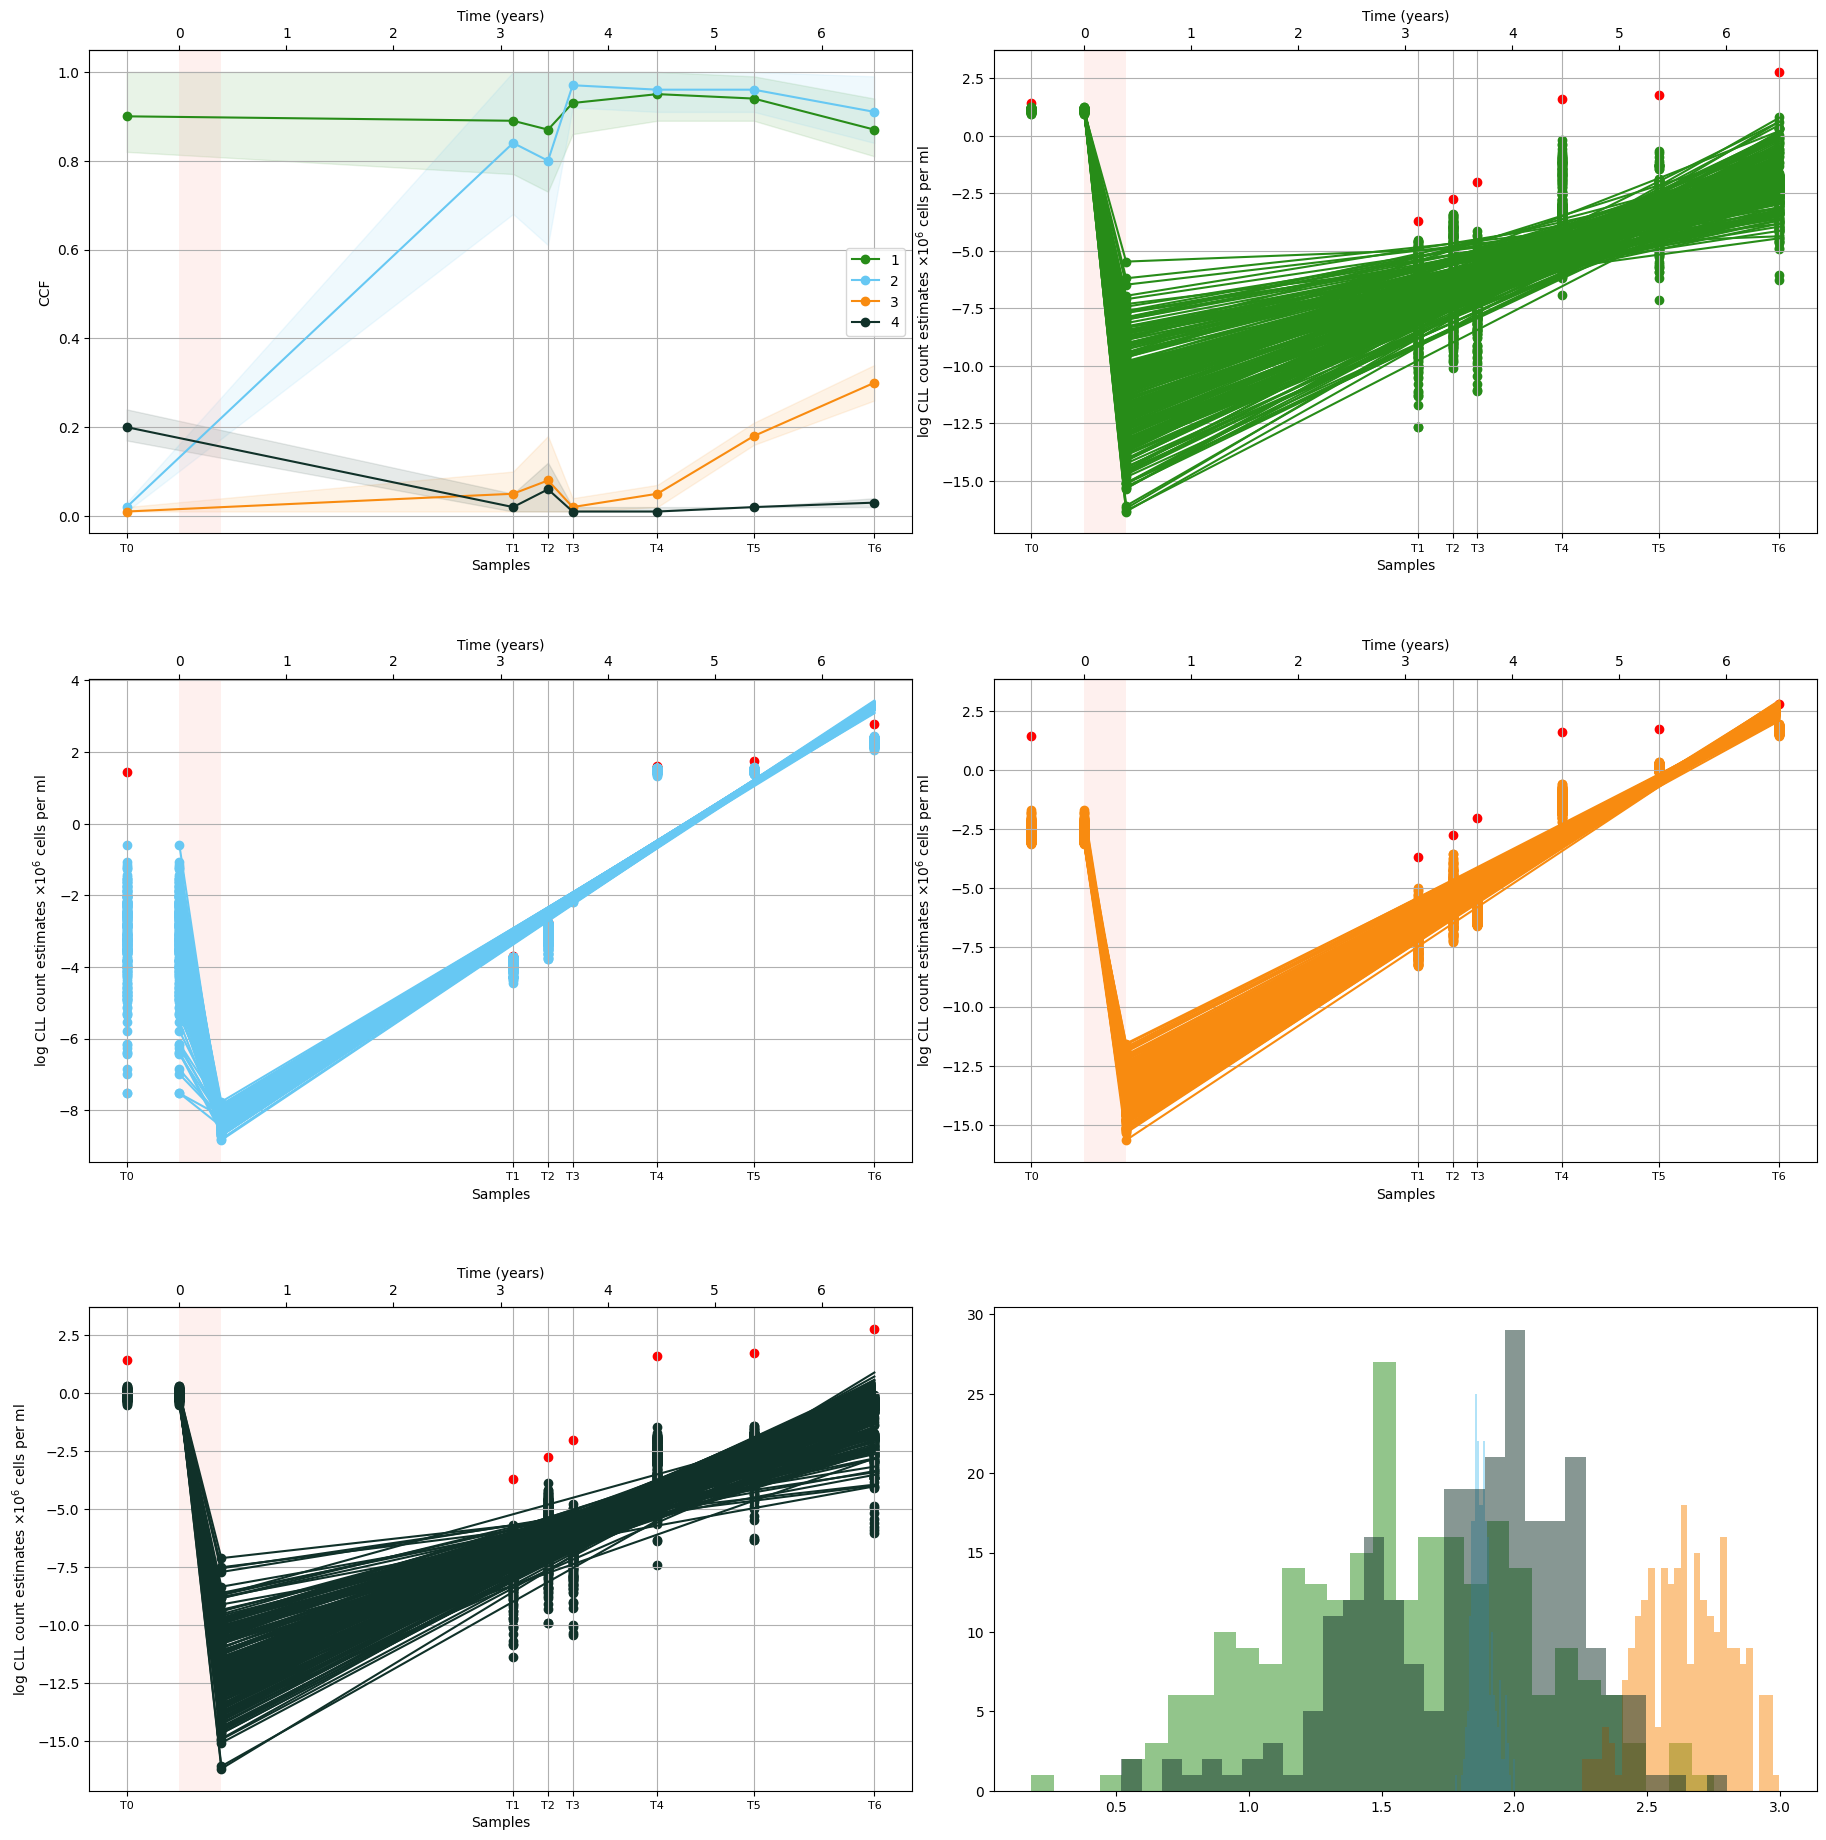

In [113]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]




slopes_mcmc = {}
def plot_sub_mcmc(ax, cluster):
    
        
    # plot total wbc
    
    x_year = [ i/365 for i in np.array(times_sample)]
    ax.scatter(x_year,np.log(CLL_count), label = 'CLL count estimate', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    
    slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)


        # Extrapolate after treatment
        extrapolate_times = times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][extrapolate_start_idx:]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)
        
        slopes_mcmc[cluster].append(model[0])
        

        predict_x = times_aft_tx
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        
        predicted_end_tx_clones.append(predicted[0])
        ax.plot(predict_year, predicted, color=ClusterColors.get_hex_string(cluster))


        times_during_tx = [0,143/365]

       

        tx_start_clones = log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx][0]

        
        ax.plot(times_during_tx, [tx_start_clones, predicted[0]], color=ClusterColors.get_hex_string(cluster), marker = 'o')

        
    


    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log CLL count estimates $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub_mcmc(ax2, 1)
plot_sub_mcmc(ax3, 2)
plot_sub_mcmc(ax4, 3)
plot_sub_mcmc(ax5, 4)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in clusters:
    ax6.hist(slopes_mcmc[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster), bins = 30)


In [115]:
for cluster in clusters:
    mean = np.mean(slopes_mcmc[cluster], axis=0)
    lower_ci = np.percentile(slopes_mcmc[cluster], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc[cluster], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")
    
    

Cluster: 1, mean:1.5639, 95% Confidence Interval: 0.6967 to 2.4311
Cluster: 2, mean:1.8817, 95% Confidence Interval: 1.8191 to 1.9726
Cluster: 3, mean:2.6496, 95% Confidence Interval: 2.3426 to 2.9498
Cluster: 4, mean:1.8306, 95% Confidence Interval: 0.8830 to 2.4419


In [32]:
# Adopt the CRC model 

from scipy.special import logsumexp 
from scipy.optimize import minimize

class MultiClusterLinearRegression:
    def __init__(self, n_clusters,X, y):
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y
        
        
    def calculate_weight_ratio(self ):
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        
        weight_ratio = num_wbc / ((num_exomes)*(self.n_clusters -1))
        return weight_ratio
        

    def objective(self, params, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        weight_ratio = self.calculate_weight_ratio()
        
        # calculate predicted y values for all clusters 
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
   
            if yi is not None:
                likelihood +=  weight_ratio * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i]))**2

        return likelihood  # We minimize negative log-likelihood



    def fit(self, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 




        
        
    def calculate_likelihood(self, params, logsumexp_points):
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts
        
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i])**2)
                print(f"exome logsubclone: {yi},exome predicted: {y_pred[i]}, likelihood_y: {likelihood_y}")
        
       
        print(f"squared sum_y: {likelihood_y}")
        
        
        likelihood_logsumexp = 0 
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i]))**2
                print(f"log wbc: {lse},wbc predicted: {logsumexp(y_pred[i])}")
        print(f"squared sum_logsumexp: {likelihood_logsumexp}")
        
        total_squared_sum = likelihood_y + likelihood_logsumexp
    
        print(f"total squared sum: {total_squared_sum}")
        return likelihood_y, likelihood_logsumexp
    


    def predict(self,):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts
    



In [33]:
def create_inputs(times_sliced, log_subclone_sample_mcmc,iter, index_samples_model):
    
    X = [ i/365 for i in np.array(times_sliced)]
    
    
    # reconstruct the dictionary so that {iteration number: cluster number :[time]}
    log_subclone_cluster_iter = {}
    
    # Iterate through each cluster
    for cluster, iterations in log_subclone_sample_mcmc.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            # Add the cluster and its value to this iteration
            log_subclone_cluster_iter[iteration][cluster] = value
    
    
    
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values)
    array_trans = array.T
    selected_sample = array_trans[index_samples_model]
    
    
    times_sample_selected = times_sample[index_samples_model]
    indices = [i for i, x in enumerate(times_sliced) if x in times_sample_selected]
    
    y = [None] * len(times_sliced)
    i = 0
    # Fill the rows that correspond with the exome points
    for index in indices: 
        y[index] = selected_sample[i]
        i +=1
    
    
    return X, y
    
    
    

In [62]:
n_clusters = 4

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,2, slice(1,7))

logsumexp_points = np.log(CLL_guess)

In [94]:
times_sliced_aft

[600, 709, 824, 1040, 1138, 1257, 1341, 1630, 1959, 2370]

In [92]:
X


[1.643835616438356,
 1.9424657534246574,
 2.2575342465753425,
 2.8493150684931505,
 3.117808219178082,
 3.4438356164383563,
 3.673972602739726,
 4.465753424657534,
 5.367123287671233,
 6.493150684931507]

In [93]:
y

[None,
 None,
 None,
 None,
 array([-5.53965991, -3.98772835, -6.78369822, -6.70860511]),
 array([-3.95719349, -3.36633965, -4.86164335, -5.66483775]),
 array([-6.6526475 , -2.09199083, -4.95539375, -6.14550193]),
 array([-3.17897745,  1.51901734, -1.3594379 , -2.15375059]),
 array([-3.64741569,  1.49603959,  0.13487473, -2.1199686 ]),
 array([-2.8013835 ,  2.22651049,  1.87735311, -2.17483511])]

In [39]:
# Convert the column "CLL count estm" to float 
wbc_df_0199['CLL count estm'] = wbc_df_0199['CLL count estm'].astype(float) 

/var/folders/x6/7zg8fddx4dlgx2lv4sv34_g40000gp/T/ipykernel_99904/3329044829.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wbc_df_0199['CLL count estm'] = wbc_df_0199['CLL count estm'].astype(float)


In [51]:
 
times_sliced_aft = [int(i) for i in wbc_df_0199[wbc_df_0199['CLL count estm'] > 0]['Time_since_start_tx'].values  if int(i) > 0]

In [52]:
times_sliced_aft

[600, 709, 824, 1040, 1138, 1257, 1341, 1630, 1959, 2370]

In [53]:
len(times_sliced_aft)

10

In [55]:
wbc_guess= np.linspace(3, 3.6, 5)


In [56]:
wbc_guess

array([3.  , 3.15, 3.3 , 3.45, 3.6 ])

In [61]:
CLL_guess = [0.00032827,
0.00105097,
0.00383106,
0.01475795,
0.02481217,
0.06480998,
0.13386660,
4.98022376,
5.75216118,
15.97161629]

In [58]:
len(CLL_guess)

10

In [63]:
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [64]:
logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]


[1.643835616438356, 1.9424657534246574, 2.2575342465753425, 2.8493150684931505, 3.117808219178082, 3.4438356164383563, 3.673972602739726, 4.465753424657534, 5.367123287671233, 6.493150684931507] [-8.02167412 -6.85804173 -5.56461375 -4.21597336 -3.69642102 -2.73629568
 -2.0109115   1.60547482  1.74957564  2.77081316]


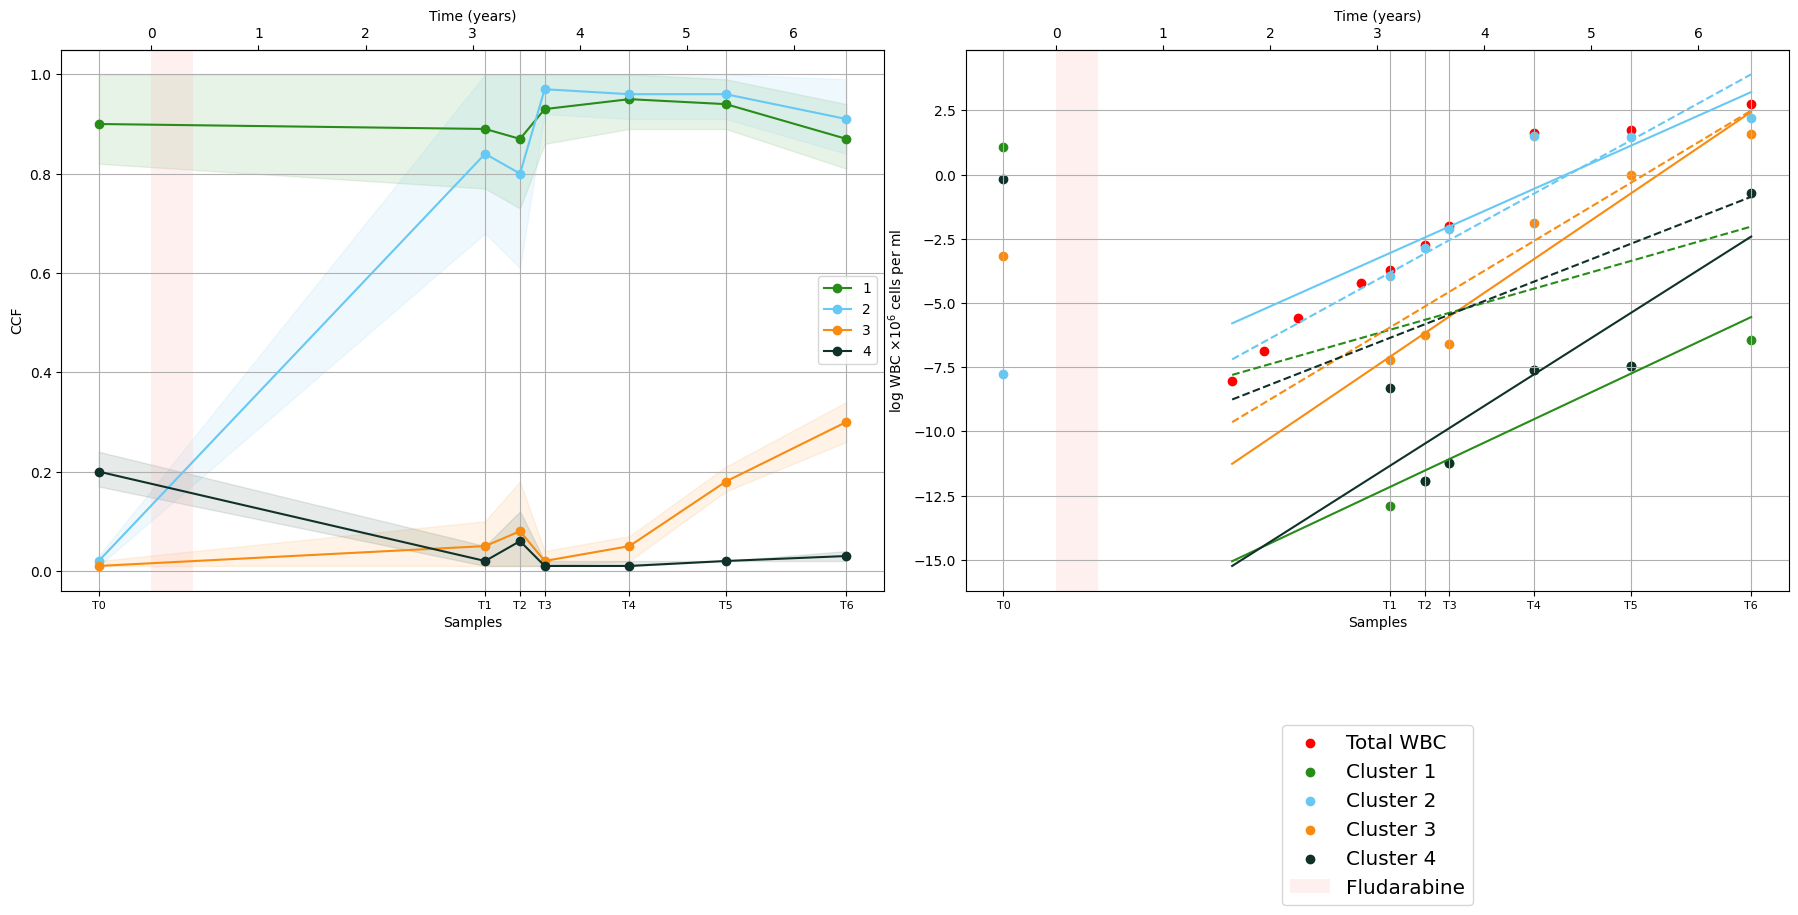

In [78]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, extrapolate_start_idx,model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    print(x_year_selected, np.log(CLL_guess),)
    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        
  
        extrapolate_times =times_sample[extrapolate_start_idx:]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        

        extrapolate_subclone = log_subclone_sample[i][extrapolate_start_idx:]
        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')
    
    
    
    

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_model_single_iter(ax2, [1,2,3, 4], extrapolate_start_idx,model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4]:

    ax2.plot(X,model.predict()[:,i-1], '--', color=ClusterColors.get_hex_string(i))
# ax2.scatter(X, logsumexp_points_model,marker='^')

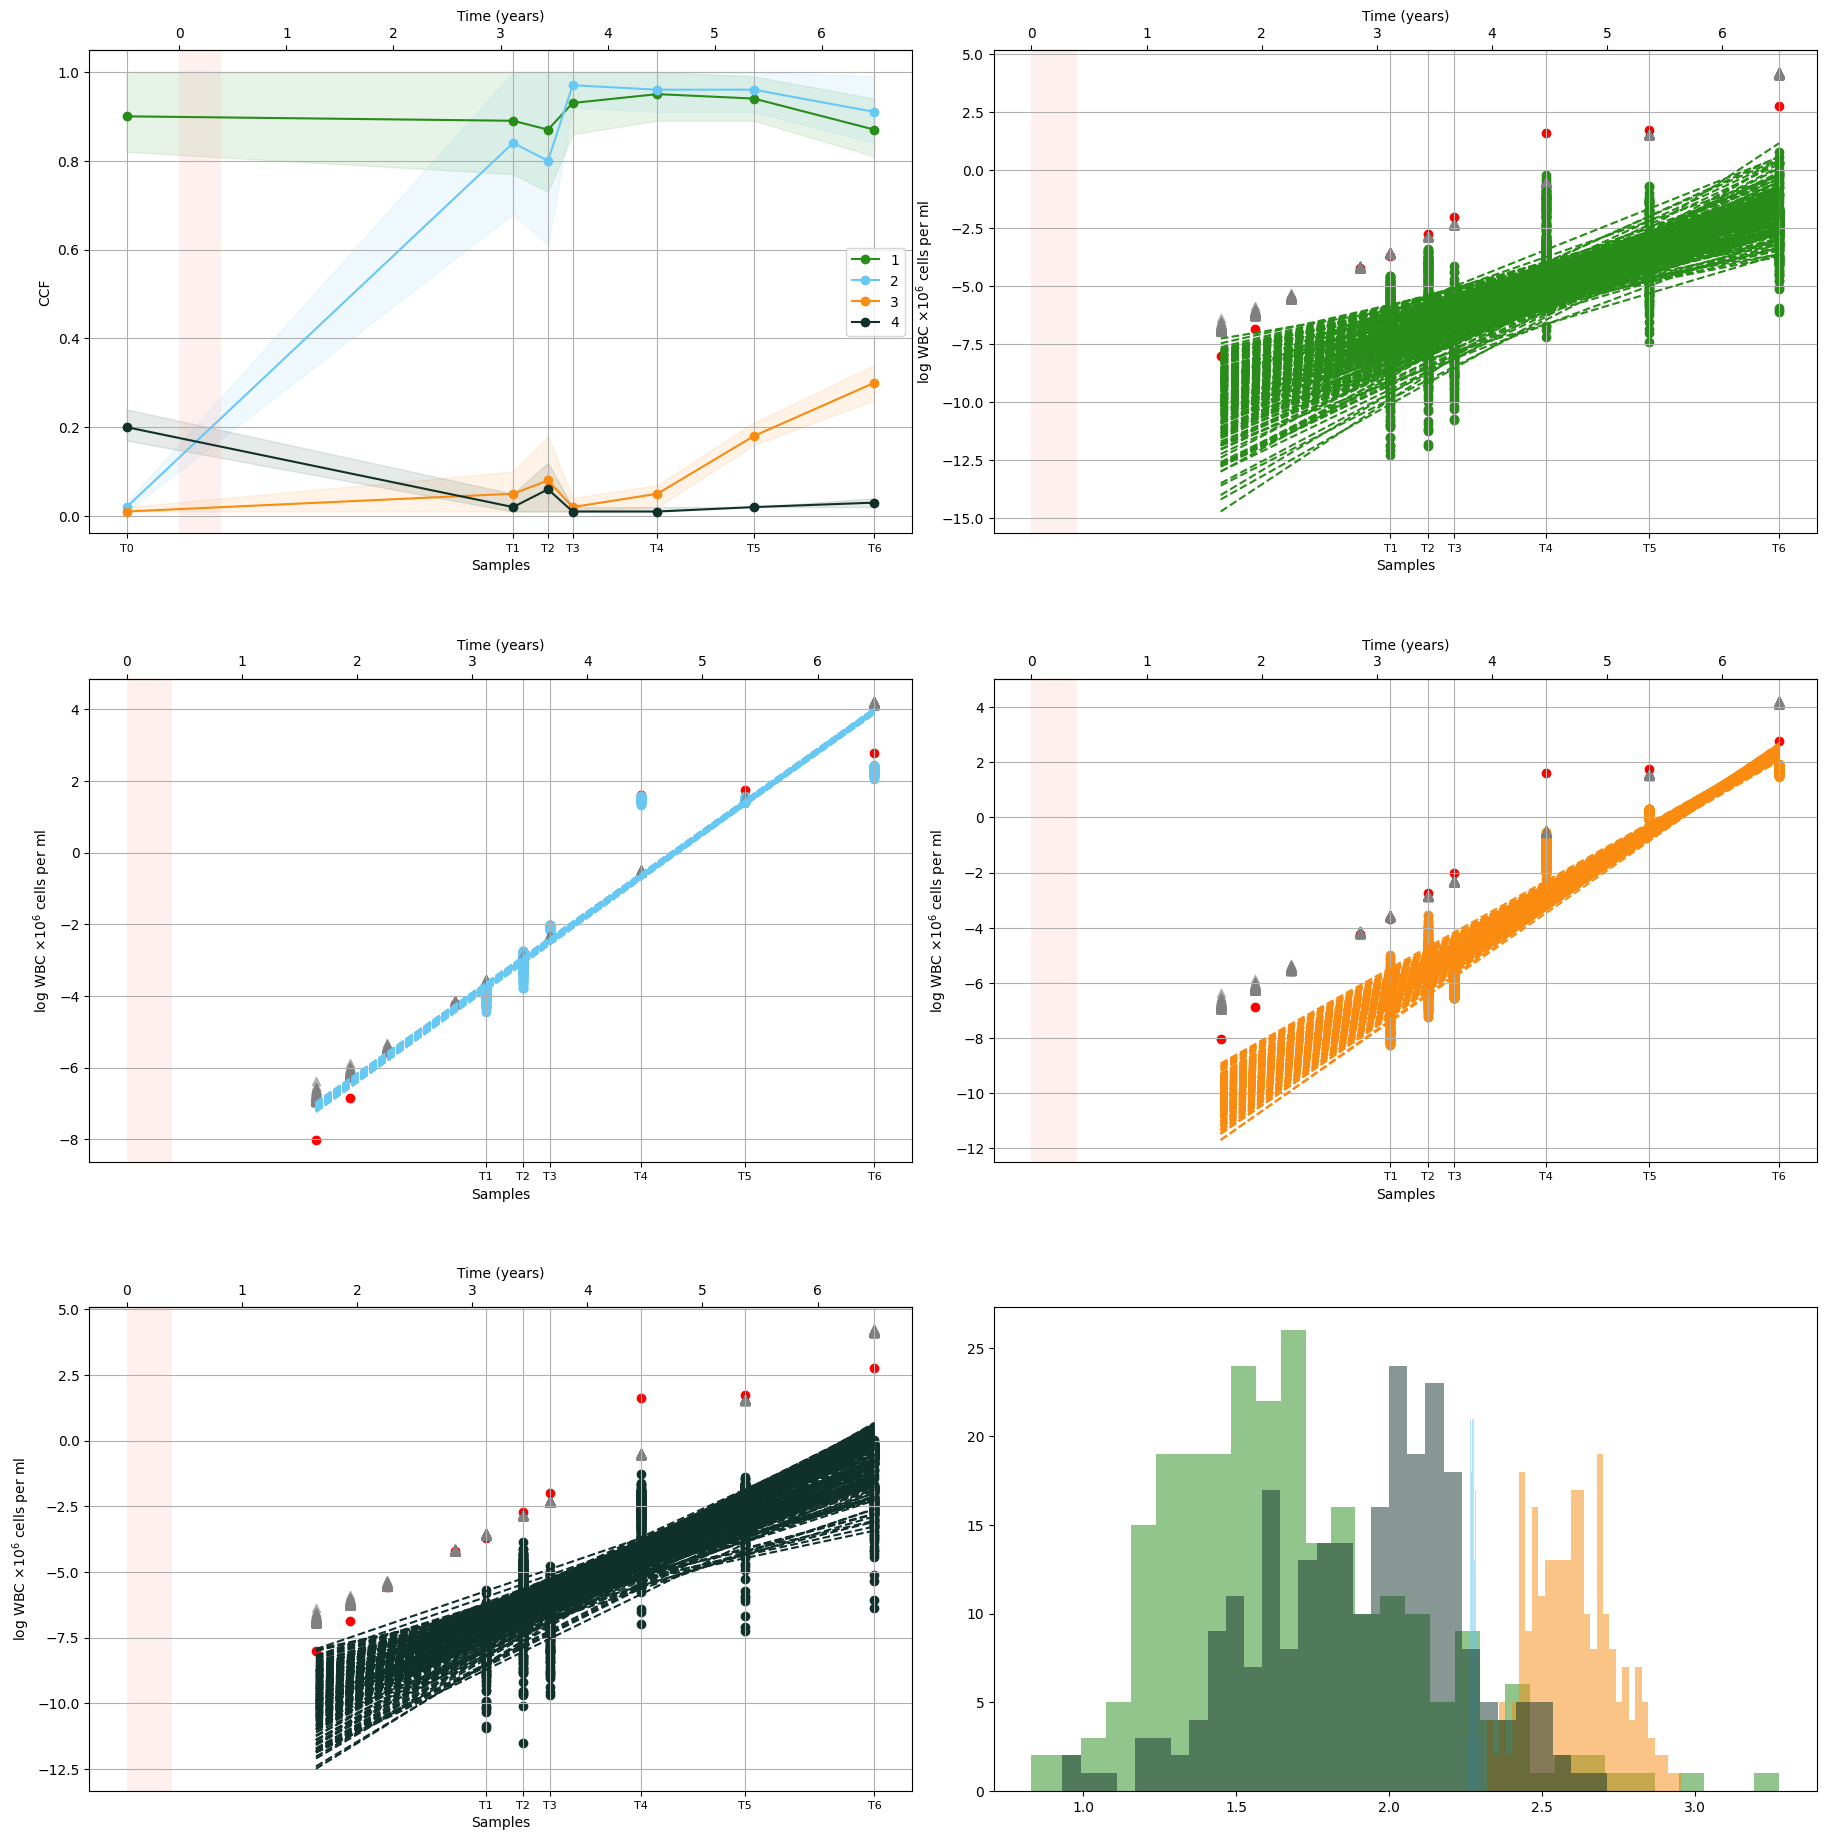

In [85]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_sliced_aft)]
    ax.scatter(x_year_selected,np.log(CLL_guess), label = 'Total WBC', c = 'red')

    # plot subclones

    

    
    
    
    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
#     slopes_mcmc[cluster]=[]
    for iter_idx in range(250):
        
        x_year = [ i/365 for i in np.array(times_sample)][1:]
        y_sub = np.array(log_subclone_sample_mcmc_with_uniform_noise[cluster][iter_idx])[1:]
        ax.scatter(x_year,y_sub,c= ClusterColors.get_hex_string(cluster),)
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(CLL_guess)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)

        
        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  
#         slopes_mcmc[cluster].append(model[0])

        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 4, index_samples_model = slice(1,7), )
plot_mcmc_model(ax3, 2, n_clusters = 4, index_samples_model = slice(1,7), )
plot_mcmc_model(ax4, 3, n_clusters = 4, index_samples_model = slice(1,7), )
plot_mcmc_model(ax5, 4, n_clusters = 4, index_samples_model = slice(1,7), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for cluster in range(n_clusters):
    ax6.hist(slopes_mcmc_transposed[cluster], alpha=0.5,color=ClusterColors.get_hex_string(cluster+1), bins = 30)



In [69]:
slopes_mcmc

{0: array([1.60693164, 2.26990786, 2.52429666, 2.3093979 ]),
 1: array([1.82977506, 2.2763353 , 2.74967508, 1.79507356]),
 2: array([1.19137894, 2.28902151, 2.50243205, 1.62799747]),
 3: array([1.69278987, 2.26591992, 2.63686354, 2.71221041]),
 4: array([1.64748082, 2.26535653, 2.7666647 , 2.19633064]),
 5: array([1.45786229, 2.28395755, 2.88107386, 1.37526668]),
 6: array([1.39811761, 2.28251699, 2.68961514, 2.00419609]),
 7: array([1.28460573, 2.30227464, 2.41593008, 1.64821812]),
 8: array([1.11833964, 2.28069512, 2.55273543, 2.4202405 ]),
 9: array([1.20915851, 2.28296878, 2.51048346, 1.82457142]),
 10: array([2.19616201, 2.26698976, 2.4610791 , 2.23695269]),
 11: array([1.54653932, 2.27177646, 2.73810806, 1.72483701]),
 12: array([2.32965684, 2.26201155, 2.69830141, 1.8561412 ]),
 13: array([1.43687524, 2.29042566, 2.67167513, 2.06914409]),
 14: array([1.716206  , 2.27797461, 2.37451421, 1.54757233]),
 15: array([1.66121735, 2.26505737, 2.63094489, 2.45895993]),
 16: array([1.6391

In [70]:
slopes_mcmc_transposed = {col: np.array([slopes_mcmc[row][col] for row in slopes_mcmc]) for col in range(len(slopes_mcmc[0]))}    

In [71]:
slopes_mcmc_transposed 

{0: array([1.60693164, 1.82977506, 1.19137894, 1.69278987, 1.64748082,
        1.45786229, 1.39811761, 1.28460573, 1.11833964, 1.20915851,
        2.19616201, 1.54653932, 2.32965684, 1.43687524, 1.716206  ,
        1.66121735, 1.63919744, 1.86253667, 1.33778766, 1.57963636,
        2.40444906, 1.98885761, 1.66709081, 1.34311375, 1.64009544,
        1.12777174, 1.18861175, 1.98320937, 1.35500706, 1.36803242,
        1.43700752, 1.07954703, 1.89994442, 1.63381193, 2.12954809,
        1.75131226, 1.96679993, 1.79845723, 1.29918594, 1.94167898,
        2.09566776, 1.89062501, 1.29324501, 1.46698495, 1.52142299,
        2.30781865, 2.7881532 , 1.26214271, 1.36235446, 1.4542414 ,
        0.97825795, 1.68207703, 1.181958  , 1.20540903, 2.06014022,
        1.61507685, 1.29889262, 1.16236177, 1.79326371, 1.59101459,
        2.43292615, 1.79077   , 2.25078585, 2.22788761, 1.35476498,
        2.42574585, 1.83051364, 1.62262246, 1.49137392, 1.97631516,
        1.79539984, 1.45161477, 1.57321122, 2

In [82]:
clusters = [1,2,3,4]
for cluster in clusters:
    mean = np.mean(slopes_mcmc_transposed[cluster-1], axis=0)
    lower_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 2.5, axis=0)
    upper_ci = np.percentile(slopes_mcmc_transposed[cluster-1], 97.5, axis=0)
    print(f"Cluster: {cluster}, mean:{mean:.4f}, 95% Confidence Interval: {lower_ci:.4f} to {upper_ci:.4f}")

Cluster: 1, mean:1.6811, 95% Confidence Interval: 1.0681 to 2.5711
Cluster: 2, mean:2.2752, 95% Confidence Interval: 2.2595 to 2.2971
Cluster: 3, mean:2.5963, 95% Confidence Interval: 2.3615 to 2.8655
Cluster: 4, mean:1.9075, 95% Confidence Interval: 1.2343 to 2.5107
